In [1]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

FOLDER_NAME = 'RT1/robotics_transformer_proj/'
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDER_NAME))
%cd /content/drive/My\ Drive/$FOLDER_NAME/

# add path to sys.path to enable import (Though it will pollute sys.path to some degree)
import os
subfolders = {'robotics_transformer',
              'robotics_transformer/train_rt1',
              'robotics_transformer/train_rt1/trajectory_transform'}
FOLDER_NAMES = [os.path.join(FOLDER_NAME, subfolder) for subfolder in subfolders]

for name in FOLDER_NAMES:
  print('folder name: ', name)
  sys.path.append('/content/drive/My Drive/{}'.format(name))


import os
print('current work dir: ', os.getcwd())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/RT1/robotics_transformer_proj
folder name:  RT1/robotics_transformer_proj/robotics_transformer
folder name:  RT1/robotics_transformer_proj/robotics_transformer/train_rt1
folder name:  RT1/robotics_transformer_proj/robotics_transformer/train_rt1/trajectory_transform
current work dir:  /content/drive/My Drive/RT1/robotics_transformer_proj


**Note**: to construct a Trajectory using stepsdataset, one must provide 'step_type' and 'next_step_type'.

'step_type' can be inferred from 'is_first', 'is_last', 'is_terminal' fields of the step, while 'next_step_type' can be inferred from the margin between 'num_steps' and 'step_id' fields

One can retrive 'num_steps' and 'step_id' fields by fixing the 'rlds_spec' (adding these two fields). And utilizing these two fields during constructing Trajectory instance.
But I am not sure whether this is a good way to do so.



In [2]:
# setup

!pip install tfds-nightly  # !!! important for accessing tfds
!pip install -q -U tf-agents
!pip install rlds[tensorflow]

In [3]:
# set up
import tensorflow as tf
import tensorflow_datasets as tfds
from PIL import Image
from IPython import display
import numpy as np

import tf_agents
from tf_agents.policies import policy_saver
from tf_agents.specs import tensor_spec

import tensor2robot
from tensor2robot.utils import tensorspec_utils
# from tf_agents.trajectories import time_step as ts
# import transformer_network
# import sequence_agent

import train_rt1
import train_rt1.training_helper as training_helper
import importlib

In [4]:
PATH_TO_DATASET = 'robotics_transformer/dataset'
print(os.path.exists(PATH_TO_DATASET))

def load_data_source(path_to_dataset=PATH_TO_DATASET):
  b = tfds.builder_from_directory(PATH_TO_DATASET)
  data_source = b.as_data_source(split='all')
  step_features = b.info.features['steps']
  print(step_features)
  return data_source, step_features


data_source, step_features = load_data_source()

True
Dataset({
    'action': FeaturesDict({
        'base_displacement_vector': Tensor(shape=(2,), dtype=float32),
        'base_displacement_vertical_rotation': Tensor(shape=(1,), dtype=float32),
        'gripper_closedness_action': Tensor(shape=(1,), dtype=float32),
        'rotation_delta': Tensor(shape=(3,), dtype=float32),
        'terminate_episode': Tensor(shape=(3,), dtype=int32),
        'world_vector': Tensor(shape=(3,), dtype=float32),
    }),
    'info': FeaturesDict({
        'discounted_return': float32,
        'return': float32,
    }),
    'is_first': bool,
    'is_last': bool,
    'is_terminal': bool,
    'num_steps': int32,
    'observation': FeaturesDict({
        'base_pose_tool_reached': Tensor(shape=(7,), dtype=float32),
        'gripper_closed': Tensor(shape=(1,), dtype=float32),
        'gripper_closedness_commanded': Tensor(shape=(1,), dtype=float32),
        'height_to_bottom': Tensor(shape=(1,), dtype=float32),
        'image': Image(shape=(256, 320, 3), dty

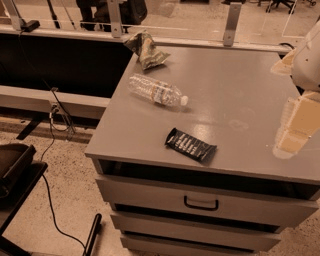

In [5]:
# show one episode

def as_gif(images, path='temp.gif'):
  images[0].save(path, save_all=True, append_images=images[1:], duration=1000, loop=0)
  gif_bytes = open(path, 'rb').read()
  return gif_bytes

step = data_source[0]['steps'][0]
display_key = 'image'
# data_source[0] if the first episode in the dataset
images = [step['observation'][display_key] for step in data_source[1]['steps']]
images = [Image.fromarray(image) for image in images]
display.Image(as_gif(images))

In [5]:
importlib.reload(train_rt1.training_helper)

agent = training_helper.create_agent()

current work dir:  /content/drive/My Drive/RT1/robotics_transformer_proj


/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


In [6]:
importlib.reload(train_rt1.training_helper)

trajectory_dataset = training_helper.get_trajectory_dataset(data_source, step_features)

current work dir:  /content/drive/My Drive/RT1/robotics_transformer_proj
trajectory transformer create pattern dataset step keys: 
dict_keys(['action', 'observation', 'info', 'is_first', 'is_last', 'is_terminal', 'num_steps', 'reward', 'step_id'])


In [11]:
from tf_agents.trajectories.time_step import StepType

for traj in trajectory_dataset.take(1):
  print(traj.keys())
  print(traj['num_steps'], traj['step_id'])
  print(traj['num_steps'] - traj['step_id'])
  margin = traj['num_steps'] - traj['step_id']
  next_step_type = tf.where(tf.greater(margin, tf.constant(3, dtype=tf.int32)), StepType.MID, StepType.LAST)

  # print(traj['step_type'], traj['next_step_type'])

dict_keys(['is_first', 'reward', 'return', 'is_terminal', 'observation', 'num_steps', 'step_id', 'step_type', 'action', 'discounted_return', 'is_last'])
tf.Tensor([73 73 73 73 73 73], shape=(6,), dtype=int32) tf.Tensor([0 1 2 3 4 5], shape=(6,), dtype=int32)
tf.Tensor([73 72 71 70 69 68], shape=(6,), dtype=int32)


In [ ]:

cnt = 0
for d in trajectory_dataset:
  cnt += 1
print(cnt)



In [7]:
from tf_agents.trajectories import Trajectory
from tf_agents.trajectories.time_step import StepType

TIME_SEQUENCE_LENGTH = 6
BATCH_SIZE = 2
BUFFER_SIZE = 1000  # 6000

def traj_map_fn(traj):  # TODO rewrite these nested step type and nested discount
  margin = traj['num_steps'] - traj['step_id']
  next_step_type = tf.where(tf.greater(margin, tf.constant(3, dtype=tf.int32)), StepType.MID, StepType.LAST)

  # nested_step_type = tf.constant(1, dtype=tf.int32)
  # nested_step_type = tf.nest.map_structure(lambda t: tf.stack([t]*TIME_SEQUENCE_LENGTH), nested_step_type)
  # nested_step_type = tf.nest.map_structure(lambda t: tf.stack([t]*BATCH_SIZE), nested_step_type)

  nested_discount = tf.constant(0., dtype=tf.float32)
  nested_discount = tf.nest.map_structure(lambda t: tf.stack([t]*TIME_SEQUENCE_LENGTH), nested_discount)
  nested_discount = tf.nest.map_structure(lambda t: tf.stack([t]*BATCH_SIZE), nested_discount)

  return Trajectory(
      step_type=traj['step_type'],
      next_step_type=next_step_type,
      # step_type=nested_step_type,
      # next_step_type=nested_step_type,
      reward=traj['reward'],
      policy_info=traj['return'],
      observation=traj['observation'],
      action=traj['action'],
      discount=nested_discount
  )

def train_one_iteration(experience):
  loss_info = agent.train(experience)
  return loss_info
  # print('loss: ', loss_info.loss)
  # print('loss info: ', loss_info)

batched_dataset = trajectory_dataset.shuffle(buffer_size=BUFFER_SIZE).batch(BATCH_SIZE).repeat(True)
batched_traj_dataset = batched_dataset.map(traj_map_fn)

epoch = 1
step_count = 0
log_interval = 50

# for _ in range(epoch):
#   for experience in batched_traj_dataset:
#     loss_info = train_one_iteration(experience)
#     step_count += 1
#     if step_count % log_interval == 0:
#       print('loss after {}-step training'.format(step_count))


experience = batched_traj_dataset.take(1)
for exp in experience:
  loss_info = train_one_iteration(exp)
  print('loss : ', loss_info.loss)
  pass

loss :  tf.Tensor(0.027386382, shape=(), dtype=float32)
